# FicEmbed Training Run on Romeo and Juliet

## Installs and Imports

In [1]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.1/757.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 60.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 59.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.0/171.0 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.

In [29]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.manifold import TSNE
import plotly.express as px

In [5]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_device

'cuda'

## Network Architecture

In [12]:
class GraphConvolution(torch.nn.Module):
    def __init__(self, character_embedding_dim, edge_dim):
        super(GraphConvolution, self).__init__()

        self.ce_dim = character_embedding_dim
        self.e_dim = edge_dim
        
        self.message_to_listener = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                 nn.Tanh())
        
        self.message_to_speaker = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                 nn.Tanh())
        
        self.listener_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), nn.Tanh())
        self.speaker_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), nn.Tanh())

    def forward(self, character_embeddings, dialogue_embeddings, speakers, listeners):
        '''
          -> (speakers intersect listeners) should be an empty set!
        '''

        character_embeddings = character_embeddings.detach()

        speaker_features = character_embeddings[speakers, :]
        listener_features = character_embeddings[listeners, :]

        speaker_listener_dialogue =  torch.cat((speaker_features - listener_features, dialogue_embeddings), dim=-1)

        # Residual connection included to avoid dying gradients
        updated_speakers = self.speaker_update(speaker_features + self.message_to_listener(speaker_listener_dialogue)) + speaker_features 
        updated_listeners = self.listener_update(listener_features + self.message_to_speaker(speaker_listener_dialogue)) + listener_features 

        out = character_embeddings.clone()
        out[speakers, :] = updated_speakers
        out[listeners, :] = updated_listeners

        return out

class GCLWithHeadBert(torch.nn.Module):
  def __init__(self, character_embedding_dim, bert_dim, edge_dim, out_dim):
    super(GCLWithHeadBert, self).__init__()

    self.bert_dim = bert_dim
    self.head = nn.Linear(2 * character_embedding_dim, out_dim)
    self.edge_translator = nn.Linear(bert_dim, edge_dim)
    self.gcn_layer = GraphConvolution(character_embedding_dim, edge_dim)
    self.activation = nn.Tanh()

  def forward(self, character_embeddings, embedding, speaker, listener):
    edge_feature = self.activation(self.edge_translator(embedding.detach())[None, :])
    updated_embeddings = self.gcn_layer(character_embeddings, edge_feature, speaker, listener)
    linear_layer_out = self.activation(self.head(torch.cat((updated_embeddings[speaker, :], updated_embeddings[listener, :]), axis=1)))
    return updated_embeddings, linear_layer_out


## Data Import and Wrangling

In [6]:
df_dialogs = pd.read_csv('rj_vadr_bert.csv').drop(columns=["Unnamed: 0"])
character_enum = pd.DataFrame(df_dialogs["speaker"].unique()).reset_index().rename(columns={0:'character'})
df_dialogs_with_speaker_enumeration = pd.merge(left=df_dialogs,
                                       right=character_enum,
                                       left_on="speaker",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'speaker_index'}).drop(columns=['character'])
df_dialogs_with_listener_enumeration = pd.merge(left=df_dialogs_with_speaker_enumeration,
                                       right=character_enum,
                                       left_on="listener",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'listener_index'}).drop(columns=['character'])
data_d = df_dialogs_with_listener_enumeration[['speaker', 'listener', 'speaker_index', 'listener_index', 'dialogue', 'dialogue_sentiment', 'avg_sentiment', 'bert']]
data = data_d.T.drop_duplicates().T
data

,speaker,listener,speaker_index,listener_index,dialogue,dialogue_sentiment,avg_sentiment,bert
0,CHORUS,SAMPSON,0,1,"Two households, both alike in dignity, In fair...",-0.5719,-0.5719,"[-0.062187887728214264, 0.04341184347867966, 0..."
1,SAMPSON,CHORUS,1,0,"Gregory, on my word, we’ll not carry coals.",0.0,0.0,"[-0.14115169644355774, 0.5629909634590149, -0...."
2,SAMPSON,GREGORY,1,2,"Gregory, on my word, we’ll not carry coals.",0.0,-0.062038,"[-0.14115169644355774, 0.5629909634590149, -0...."
3,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
4,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
...,...,...,...,...,...,...,...,...
1681,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1682,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1683,CAPULET,MONTAGUE,7,9,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,-0.127267,"[-0.21812646090984344, 0.143050417304039, -0.1..."
1684,CAPULET,PRINCE,7,11,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,0.062967,"[-0.21812646090984344, 0.143050417304039, -0.1..."


In [7]:
train_data = data.iloc[:int(0.6*len(data))]
valid_data = data.iloc[int(0.6*len(data)):int(0.8*len(data))]
test_data = data.iloc[int(0.8*len(data)):]
print(f"Sizes: train {len(train_data)}, valid {len(valid_data)}, test {len(test_data)}")

Sizes: train 1011, valid 337, test 338


## Training

In [14]:
# Hyperparameters
character_embedding_dim = 16
bert_dim = 768
edge_dim = 16
epochs = 1
iters_per_dialog = 1

In [9]:
# Data extraction functions 
def get_ground_truth(datapoint):
    return datapoint['dialogue_sentiment']

def get_bert_embedding(datapoint):
    return datapoint['bert']

def get_speaker(datapoint):
    return datapoint['speaker_index']

def get_listener(datapoint):
    return datapoint['listener_index']

def get_dialogue(datapoint):
    return datapoint['dialogue']

In [26]:

def train_loop(model, optimizer, criterion, character_embeddings, train_data, valid_data, hyperparameters, print_every = 1000):
  # Character embeddings are randomly initialized
  torch.autograd.set_detect_anomaly(True)
  losses = {}
  all_losses = []

  print('Running training dialogues:', len(train_data))
  epochs = hyperparameters['epochs']
  iters_per_dialog = hyperparameters['iters_per_dialog']
  for epoch in range(epochs):
    for index, row in tqdm.tqdm(train_data.iterrows()):
      for j in range(iters_per_dialog):

        # Fetch ground truth
        dialog_gt = row['dialogue_sentiment']
        y = torch.tensor(dialog_gt).view(-1, 1).to(torch_device) 

        # Fetch embeddings
        bert_val = get_bert_embedding(row)
        bert_row = np.array([float(val) for val in bert_val.strip('][').split(', ')])
        bert_embed = torch.from_numpy(bert_row).float().to(torch_device)

        # Fetch speaker and listener
        speaker = torch.tensor([row['speaker_index']]).to(torch_device)
        listener = torch.tensor([row['listener_index']]).to(torch_device)

        character_embeddings, y_pred = model(character_embeddings, bert_embed, speaker, 
                                            listener) 
        
        # Compute and print loss
        loss = criterion(y_pred, y)
        all_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if index % print_every == 0 and j == iters_per_dialog - 1:
          plt.plot(all_losses)
          plt.xlim(0, len(train_data) * epochs)
          plt.show()
          print(f'Epoch {epoch}, loss {loss.item()}')
      
        chars = [row['speaker'], row['listener']]
        chars.sort()
        key = chars[0] + ';' + chars[1]
        losses[key] = losses.get(key, [])
        losses[key].append(loss.cpu().detach().numpy())

        all_losses += [float(loss.cpu().detach().numpy())] 
  
  return losses, all_losses

Running training dialogues: 1011


0it [00:00, ?it/s]

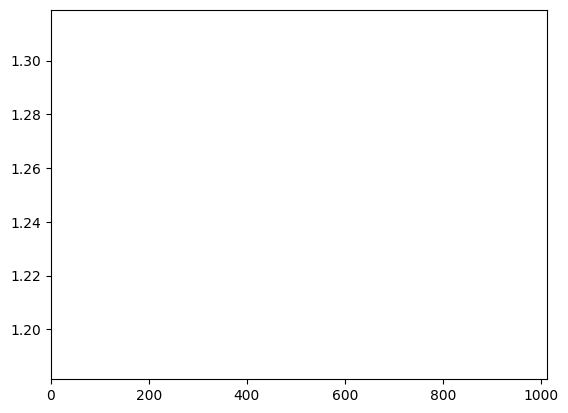

4it [00:00, 38.84it/s]

Epoch 0, loss 1.2501682043075562


92it [00:00, 104.31it/s]

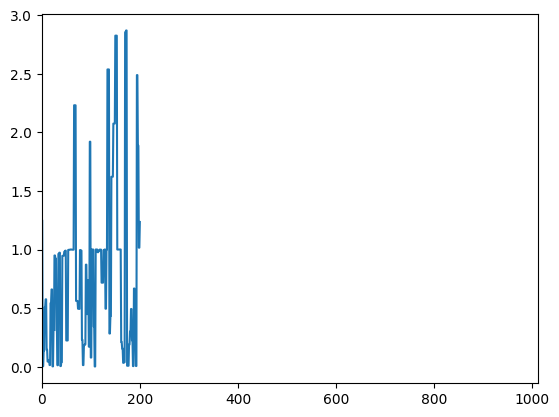

114it [00:01, 92.27it/s]

Epoch 0, loss 1.2349739074707031


191it [00:01, 104.69it/s]

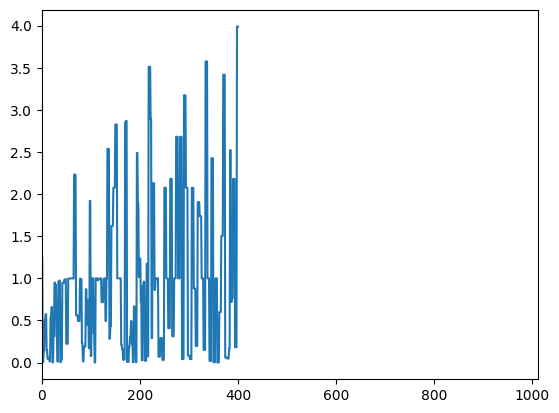

213it [00:02, 91.97it/s] 

Epoch 0, loss 3.985889434814453


290it [00:02, 104.74it/s]

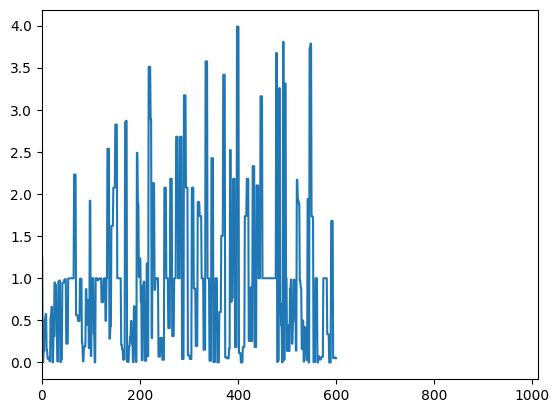

312it [00:03, 91.37it/s] 

Epoch 0, loss 0.04978164657950401


400it [00:04, 105.21it/s]

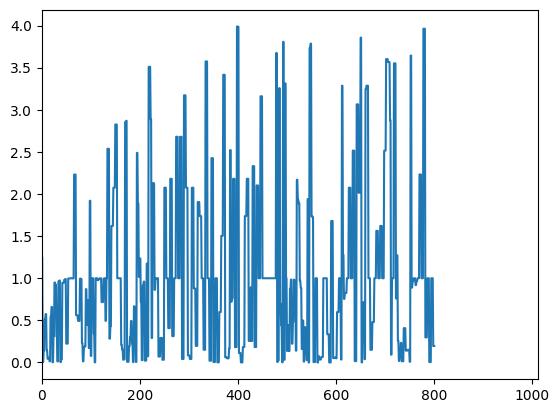

411it [00:04, 85.75it/s] 

Epoch 0, loss 0.1958947777748108


499it [00:05, 104.34it/s]

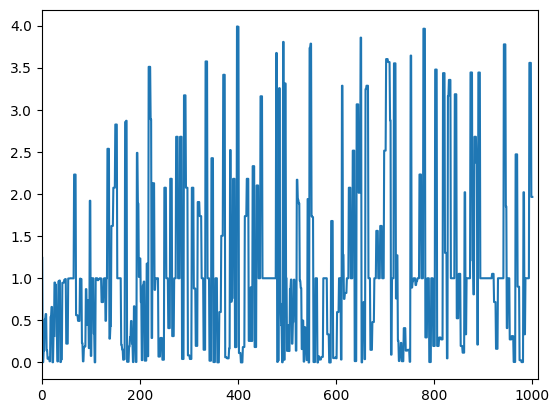

521it [00:05, 89.92it/s] 

Epoch 0, loss 1.965323805809021


598it [00:06, 104.40it/s]

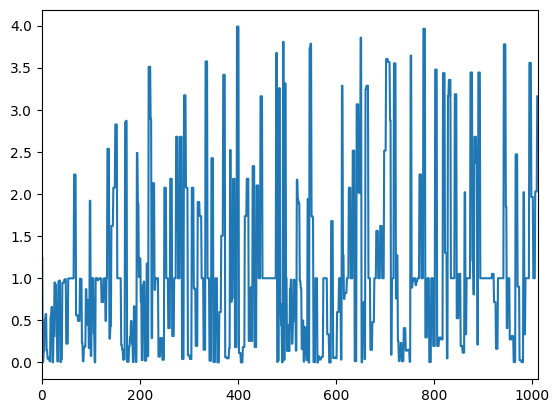

620it [00:06, 90.64it/s] 

Epoch 0, loss 3.3215062618255615


697it [00:07, 102.99it/s]

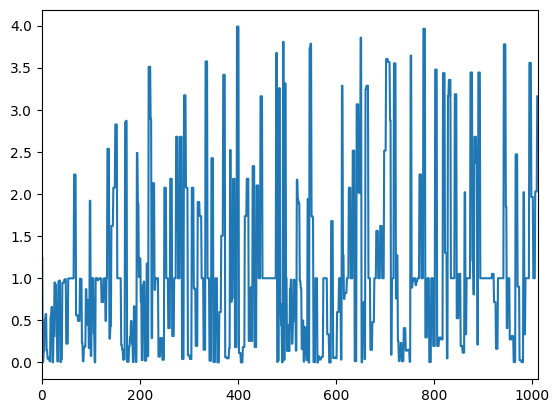

719it [00:07, 89.83it/s] 

Epoch 0, loss 2.180643081665039


796it [00:08, 102.81it/s]

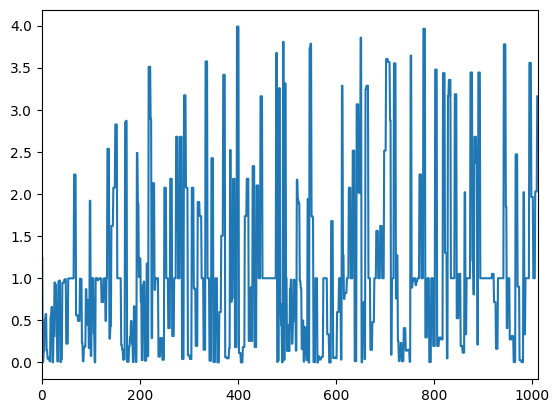

818it [00:08, 89.62it/s] 

Epoch 0, loss 3.247204065322876


895it [00:09, 102.45it/s]

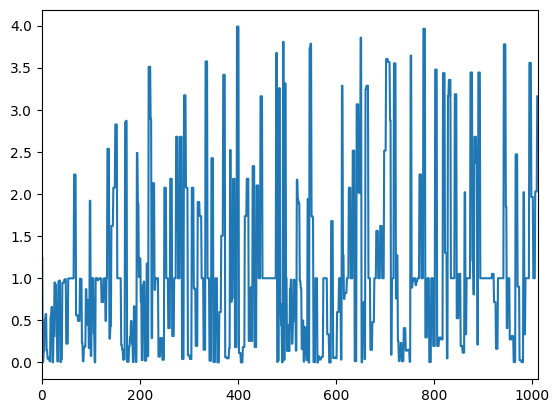

917it [00:09, 82.21it/s] 

Epoch 0, loss 1.0


994it [00:10, 102.32it/s]

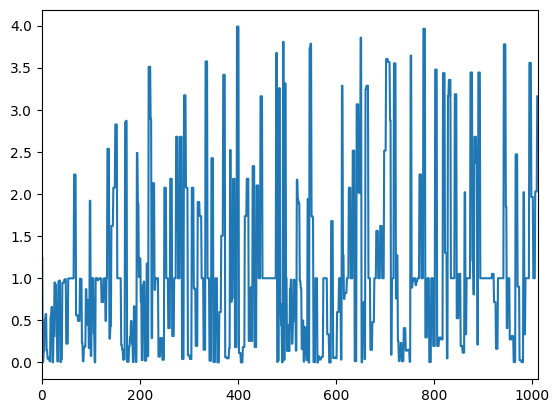

1011it [00:10, 96.08it/s]

Epoch 0, loss 1.0


In [27]:
# Run the training loop
hyperparameters = {'epochs': epochs, 'iters_per_dialog': iters_per_dialog}
model = GCLWithHeadBert(character_embedding_dim, bert_dim, edge_dim, 1).to(torch_device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
character_embeddings = torch.rand((len(character_enum), character_embedding_dim)).to(torch_device)
losses, all_losses = train_loop(model, optimizer, criterion, character_embeddings, train_data, valid_data, hyperparameters, print_every = 100)

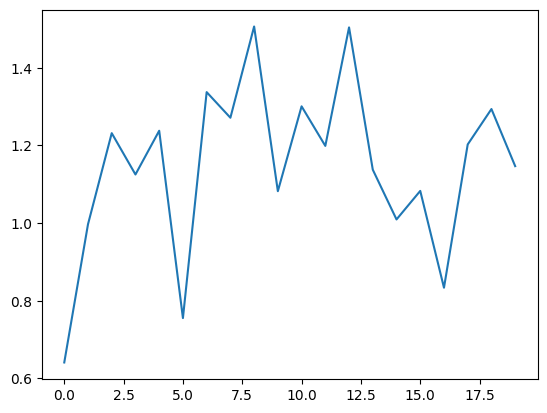

In [28]:
def get_avg_losses(loss, size):
    """
    For the list of losses, create a new list averaging together every size elements
    """
    avg_loss = []
    for i in range(0, len(loss), size):
        avg_loss.append(sum(loss[i:i+size])/size)
    return avg_loss[:-1]
  
avg_losses = get_avg_losses(all_losses, 100)
plt.plot(avg_losses)

## Evaluation Loop

In [30]:
def eval_loop(model, criterion, character_embeddings, test_data):
  correct, incorrect = 0, 0
  losses = []
  for index, row in tqdm.tqdm(test_data.iterrows()):
    dialog_gt = row['dialogue_sentiment']
    y = torch.tensor(dialog_gt).view(-1, 1).to(torch_device)
    
    # Forward pass: Compute predicted y by passing x to the model
    bert_value = get_bert_embedding(row)
    bert_row = np.array([float(val) for val in bert_value.strip('][').split(', ')])
    bert_embed = torch.from_numpy(bert_row).float().to(torch_device)
    speaker = torch.tensor([get_speaker(row)]).to(torch_device)
    listener = torch.tensor([get_listener(row)]).to(torch_device)

    with torch.no_grad():
      character_embeddings, y_pred = model(character_embeddings, bert_embed, speaker, 
                                            listener)
      
    # if y_pred and y are the same sign, increment correct, else increment incorrect
    if y_pred.item() * y.item() > 0:
      correct += 1
    else:
      incorrect += 1

    # Compute and print loss
    loss = criterion(y_pred, y)
    losses.append(loss.item())


  # printing correctness/incorrect measured by direction
  print('accuracy', incorrect/(correct + incorrect))

  # printing accuracy based on loss
  loss_np = np.array(losses)
  accuracies = []
  for boundary in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    boolean = loss_np[loss_np <= boundary]
    print(f"With error margin {boundary}, accuracy = {len(boolean) / len(loss_np)}")
    accuracies.append(len(boolean) / len(loss_np))
  plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], accuracies, label='MSE Loss')
  plt.xlabel('Margin')
  plt.ylabel('Percent within Margin')
  plt.title('Loss Percent within Loss Margin')

338it [00:00, 1050.27it/s]

accuracy 0.5828402366863905
With error margin 0.1, accuracy = 0.20118343195266272
With error margin 0.2, accuracy = 0.257396449704142
With error margin 0.3, accuracy = 0.32840236686390534
With error margin 0.4, accuracy = 0.3816568047337278
With error margin 0.5, accuracy = 0.40828402366863903
With error margin 0.6, accuracy = 0.41124260355029585
With error margin 0.7, accuracy = 0.41124260355029585
With error margin 0.8, accuracy = 0.42011834319526625
With error margin 0.9, accuracy = 0.4378698224852071
With error margin 1, accuracy = 0.7485207100591716


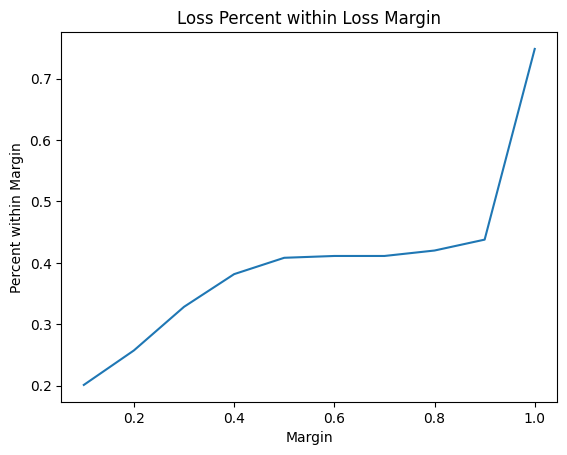

In [31]:
eval_loop(model, criterion, character_embeddings, test_data)

## Plotting Embeddings

In [32]:
# create a 2D plot of the vectors
def plot_2d(vectors, labels):
    tsne = TSNE(n_components=2, perplexity=1, random_state=0)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)
    labels = labels

    df = px.data.iris()
    fig = px.scatter(x=T[:,0], y=T[:,1], color=labels)
    fig.show()

In [35]:
plot_2d(character_embeddings.cpu().detach().numpy(), character_enum['character'])

/home/amks/ficembed/env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/amks/ficembed/env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Manual Testing

In [20]:
character_translation = {index: name for index, name in enumerate(character_enum['character'])}
juliet_side = ["JULIET", "NURSE", "LADY CAPULET", "CAPULET"]
romeo_side = ["ROMEO", "FRIAR LAWRENCE", "FRIAR JOHN", "BALTHASAR", "MERCUTIO", "BENVOLIO", "MONTAGUE"]
evil_side = ["TYBALT", "PARIS", "PRINCE", "APOTHECARY"]

name_to_index = {v:k for k,v in character_translation.items()}
juliet_indices = [name_to_index[name] for name in juliet_side]
romeo_indices = [name_to_index[name] for name in romeo_side]
evil_indices = [name_to_index[name] for name in evil_side]

juliet_friends = [character_embeddings[index].detach().cpu().numpy() for index in juliet_indices]
romeo_friends = [character_embeddings[index].detach().cpu().numpy() for index in romeo_indices]
evil_friends = [character_embeddings[index].detach().cpu().numpy() for index in evil_indices]

juliet = juliet_friends[0]
romeo = romeo_friends[0]

juliet_distances = [np.linalg.norm(juliet - friend) for friend in juliet_friends]
romeo_distances = [np.linalg.norm(romeo - friend) for friend in romeo_friends]

juliet_romeo_distances = [np.linalg.norm(juliet - other) for other in romeo_friends]
juliet_evil_distances = [np.linalg.norm(juliet - other) for other in evil_friends]

romeo_juliet_distances = [np.linalg.norm(romeo - other) for other in juliet_friends]
romeo_evil_distances = [np.linalg.norm(romeo - other) for other in evil_friends]

print(np.mean(juliet_distances), np.mean(juliet_romeo_distances), np.mean(juliet_evil_distances))
print(np.mean(romeo_distances), np.mean(romeo_juliet_distances), np.mean(romeo_evil_distances))

439.7364 839.60925 982.7593
990.9806 1005.0215 1274.4503
